# Setup



In [ ]:
#@title
!pip install cobra

# Model Building and Analysis

In [ ]:
# Set up a model for the wild type E. coli strain used in the paper.

import cobra.test
model = cobra.test.create_test_model("ecoli")

In [ ]:
# print(model.reactions)

In [ ]:
# Set constraints for aerobic growth in glucose minimal media
model.reactions.get_by_id( 'EX_glc__D_e').lower_bound= -10
model.reactions.get_by_id( 'EX_o2_e').lower_bound = -15

In [ ]:
#Add crtEBI pathway for lycopene production
#Hint: see Alper et al 2005 Met Eng, Supp Info for reactions
#New metabolites: ggpp_c, phyto_c, lyco_c
from cobra import Metabolite
coa_c = model.metabolites.get_by_id( 'coa_c')
ipdp_c = model.metabolites.get_by_id( 'ipdp_c')
frdp_c = model.metabolites.get_by_id( 'frdp_c')
ppi_c = model.metabolites.get_by_id( 'ppi_c')
nadp_c = model.metabolites.get_by_id( 'nadp_c')
nadph_c = model.metabolites.get_by_id( 'nadph_c')
#Create new metabolites
ggpp_c = Metabolite( 'ggpp_c', formula='C20H36O7P2', name='Geranylgeranyl Pyrophospate', compartment ='c')
phyto_c = Metabolite( 'phyto_c', formula='C40H64', name='Phytoene', compartment ='c')
lyco_c = Metabolite( 'lyco_c', formula='C40H56', name='Lycopene', compartment ='c')

In [ ]:
#New reactions: CRTE, CRTB, CRTI, LYCO-dem
from cobra import Reaction
#add CRTE:
reaction1 = Reaction('CRTE')
reaction1.name = 'Geranylgeranyl diphosphate (GGPP) synthase'
reaction1.subsystem = 'Lycopene biosynthesis'
reaction1.lower_bound = 0
reaction1.upper_bound = 1000
reaction1.add_metabolites({ipdp_c: -1.0, frdp_c: -1.0, ggpp_c: 1.0, ppi_c: 1.0})
model.add_reaction(reaction1)
#add CRTB:
reaction2 = Reaction('CRTB')
reaction2.name = 'Phytoene synthase'
reaction2.subsystem = 'Lycopene biosynthesis'
reaction2.lower_bound = 0
reaction2.upper_bound = 1000
reaction2.add_metabolites({ggpp_c: -2.0, phyto_c: 1.0, ppi_c: 1.0})
model.add_reaction(reaction2)
#add CRTI:
reaction3 = Reaction('CRTI')
reaction3.name = 'Phytoene desaturase'
reaction3.subsystem = 'Lycopene biosynthesis'
reaction3.lower_bound = 0
reaction3.upper_bound = 1000
reaction3.add_metabolites({phyto_c: -1.0, nadp_c: -8.0, lyco_c: 1.0, nadph_c: 8.0})
model.add_reaction(reaction3)
#add LYCO-dem:
reaction4 = Reaction('LYCO-dem')
reaction4.name = 'Lycopene demand'
reaction4.subsystem = 'Lycopene biosynthesis'
reaction4.lower_bound = 0
reaction4.upper_bound = 1000
reaction4.add_metabolites({lyco_c: -1.0})
model.add_reaction(reaction4)

In [ ]:
print(f'{len(model.reactions)} reactions')
print(f'{len(model.metabolites)} metabolites')
print(f'{len(model.genes)} genes')

2587 reactions
1808 metabolites
1367 genes


In [ ]:
print('Default-core_53p95M-value:', model.reactions.get_by_id('BIOMASS_Ec_iJO1366_core_53p95M').objective_coefficient)
print('Default-WT_53p95M-value:', model.reactions.get_by_id('BIOMASS_Ec_iJO1366_WT_53p95M').objective_coefficient)
print('Default-LYCO-dem-value:', model.reactions.get_by_id('LYCO-dem').objective_coefficient)

Default-core_53p95M-value: 1.0
Default-WT_53p95M-value: 0
Default-LYCO-dem-value: 0


We create a pandas dataframe to save all our results.

In [ ]:
import pandas as pd
knockout_combinations = pd.DataFrame(columns=['Genes', 'GeneIDs', 'Growth Rate', 'Lycopene Production Yield', 'Lycopene Yield', 'Overexpression'])

## What is the theoretical maximum yield of lycopene (mol lycopene/mol glucose)?

In [ ]:
model.reactions.get_by_id('BIOMASS_Ec_iJO1366_core_53p95M').objective_coefficient = 0
model.reactions.get_by_id('BIOMASS_Ec_iJO1366_WT_53p95M').objective_coefficient = 0
model.reactions.get_by_id('LYCO-dem').objective_coefficient = 1.0

In [ ]:
solution = model.optimize()

In [ ]:
print('Growth Rate (1/h): ' + str(solution.get_primal_by_id('BIOMASS_Ec_iJO1366_WT_53p95M')))
print('Lycopene Production Rate (mmol/gdcw/h): ' + str(solution.get_primal_by_id('LYCO-dem')))
print('Lycopene Yield (mol/mol glucose): ' +
str(-solution.get_primal_by_id('LYCO-dem')/solution.get_primal_by_id('EX_glc__D_e')))
knockout_combinations = knockout_combinations.append({'GeneIDs' : "", 
     'Genes': "None",
     'Growth Rate' : solution.get_primal_by_id('BIOMASS_Ec_iJO1366_WT_53p95M'), 
     'Lycopene Production Yield' : solution.get_primal_by_id('LYCO-dem'), 
     'Lycopene Yield' : -solution.get_primal_by_id('LYCO-dem')/solution.get_primal_by_id('EX_glc__D_e'),
     'Overexpression' : 'theoretical'},
    ignore_index=True)

Growth Rate (1/h): 0.0
Lycopene Production Rate (mmol/gdcw/h): 1.1019165727170237
Lycopene Yield (mol/mol glucose): 0.11019165727170237


In [ ]:
model.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
glc__D_e,EX_glc__D_e,10,6,100.00%
h_e,EX_h_e,9.917,0,0.00%
o2_e,EX_o2_e,2.7,0,0.00%
pi_e,EX_pi_e,2.204,0,0.00%
Metabolite,Reaction,Flux,C-Number,C-Flux
co2_e,EX_co2_e,-15.92,1,26.54%
h2o_e,EX_h2o_e,-34.66,0,0.00%
lyco_c,LYCO-dem,-1.102,40,73.46%


## How much lycopene is produced by the wild type strain that has been extended with the lycopene pathway?

In [ ]:
model.reactions.get_by_id('BIOMASS_Ec_iJO1366_core_53p95M').objective_coefficient = 0
model.reactions.get_by_id('BIOMASS_Ec_iJO1366_WT_53p95M').objective_coefficient = 1.0
model.reactions.get_by_id('LYCO-dem').objective_coefficient = 0

In [ ]:
solution = model.optimize()

In [ ]:
print('Growth Rate (1/h): ' + str(solution.get_primal_by_id('BIOMASS_Ec_iJO1366_WT_53p95M')))
print('Lycopene Production Rate (mmol/gdcw/h): ' + str(solution.get_primal_by_id('LYCO-dem')))
print('Lycopene Yield (mol/mol glucose): ' +
str(-solution.get_primal_by_id('LYCO-dem')/solution.get_primal_by_id('EX_glc__D_e')))
knockout_combinations = knockout_combinations.append({'GeneIDs' : "", 
     'Genes': "None",
     'Growth Rate' : solution.get_primal_by_id('BIOMASS_Ec_iJO1366_WT_53p95M'), 
     'Lycopene Production Yield' : solution.get_primal_by_id('LYCO-dem'), 
     'Lycopene Yield' : -solution.get_primal_by_id('LYCO-dem')/solution.get_primal_by_id('EX_glc__D_e'),
     'Overexpression' : 'real'},
    ignore_index=True)

Growth Rate (1/h): 0.9009127876086879
Lycopene Production Rate (mmol/gdcw/h): 0.0
Lycopene Yield (mol/mol glucose): 0.0


In [ ]:
model.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
ca2_e,EX_ca2_e,0.004461,0,0.00%
cbl1_e,EX_cbl1_e,0.0002009,62,0.02%
cl_e,EX_cl_e,0.004461,0,0.00%
cobalt2_e,EX_cobalt2_e,2.162E-05,0,0.00%
cu2_e,EX_cu2_e,0.0006072,0,0.00%
fe2_e,EX_fe2_e,0.007296,0,0.00%
fe3_e,EX_fe3_e,0.006692,0,0.00%
glc__D_e,EX_glc__D_e,10,6,99.98%
k_e,EX_k_e,0.1673,0,0.00%
mg2_e,EX_mg2_e,0.007435,0,0.00%


## How much lycopene is produced in mutant strains with gene knockouts?
(Knockouts are defined in the [paper](https://www.nature.com/articles/nbt1083).)

In the paper they found the Knockouts statistically and combinatorial.
This table shows the Knockouts from Figure 1:

| Statistical | Combinatoral |
| - | - |
| gdhA | yjiD |
| aceE | rssB |
| ytjC (gpmB) | yjfP |
| fdhF | |

In the other [paper](https://www.researchgate.net/publication/7854770_Identifying_gene_targets_for_the_metabolic_engineering_of_lycopene_biosynthesis_in_Escherichia_coli) knockouts in *gdhA*, *gpma*, *gpmb (=ytjC)*, *aceE*, and   *fdhf* were conducted. These are the same knockouts.

We can find the IDs of the genes in the [supplementary information](https://www.embopress.org/action/downloadSupplement?doi=10.1038%2Fmsb.2011.65&file=msb201165-sup-0002.xls)(table 7) to a [paper by Orth 2011](https://www.embopress.org/doi/full/10.1038/msb.2011.65). To do so we have to connect the function of the gene and look it up in the table.

This are the resulting IDs:

| Gene | ID | Function | 
| - | - | - |
| gdhA | b1761 | glutamate dehydrogenase |
| aceE | b0114 | pyruvate dehydrogenase |
| ytjC | b4395 | Phosphoglucomuatase II |
| fdhF | b4079 | Formate dehydrogenase H|
| yjiD | NA | 130-aa hypothetical protein |
| rssB | NA | Member, two-component systems, σ^S degradation |
| yjfP | NA | 294-aa hypothetical protein |

The hypothetical proteins are not distinct in the table. rssB is missing in the model. Therefore, we can only use the statistically found knockouts.

In [ ]:
import itertools

knockout_ids = {'b1761': 'gdhA', 'b0114': 'aceE', 'b4395': 'yjtC', 'b4079': 'fdhF'}

We also need to set the model back to the theoretical values, so Lycopene is actually produced.

In [ ]:
model.reactions.get_by_id('BIOMASS_Ec_iJO1366_core_53p95M').objective_coefficient = 0
model.reactions.get_by_id('BIOMASS_Ec_iJO1366_WT_53p95M').objective_coefficient = 0
model.reactions.get_by_id('LYCO-dem').objective_coefficient = 1

In [ ]:
solution = model.optimize()

We define the Growth Rate (1/h), the Lycopene Production Rate (mmol/gdcw/h), and the Lycopene Yield (mol/mol glucose) for every possible combination of the four genes.

In [ ]:
from cobra.manipulation import delete_model_genes, undelete_model_genes

In [ ]:
for combination in itertools.chain(*[list(itertools.combinations(knockout_ids.keys(), i)) for i in range(1,5)]):
  ids = '-'.join(combination)
  delete_model_genes(model, combination)
  # for gene in combination:
  #   model.genes.get_by_id(gene).knock_out()
  # for gene in combination:
  #   print(gene, model.genes.get_by_id(gene).functional)
  solution = model.optimize()
  knockout_combinations = knockout_combinations.append(
    {'GeneIDs' : ids, 
     'Genes': '-'.join(map(knockout_ids.get, combination)),
     'Growth Rate' : solution.get_primal_by_id('BIOMASS_Ec_iJO1366_WT_53p95M'), 
     'Lycopene Production Yield' : solution.get_primal_by_id('LYCO-dem'), 
     'Lycopene Yield' : -solution.get_primal_by_id('LYCO-dem')/solution.get_primal_by_id('EX_glc__D_e'),
     'Overexpression' : 'theoretical'},
    ignore_index=True
  )
  undelete_model_genes(model)

  # for gene in combination:
  #   model.genes.get_by_id(gene).functional = True
    
knockout_combinations

,Genes,GeneIDs,Growth Rate,Lycopene Production Yield,Lycopene Yield,Overexpression
0,None,,0.000000,1.101917,0.110192,theoretical
1,None,,0.900913,0.000000,0.000000,real
2,gdhA,b1761,0.000000,1.101917,0.110192,theoretical
3,aceE,b0114,0.000000,1.101917,0.110192,theoretical
4,yjtC,b4395,0.000000,1.101917,0.110192,theoretical
5,fdhF,b4079,0.000000,1.101917,0.110192,theoretical
6,gdhA-aceE,b1761-b0114,0.000000,1.101917,0.110192,theoretical
7,gdhA-yjtC,b1761-b4395,0.000000,1.101917,0.110192,theoretical
8,gdhA-fdhF,b1761-b4079,0.000000,1.101917,0.110192,theoretical
9,aceE-yjtC,b0114-b4395,0.000000,1.101917,0.110192,theoretical


We also add a model with the real Lycopene yield:

In [ ]:
model.reactions.get_by_id('BIOMASS_Ec_iJO1366_core_53p95M').objective_coefficient = 0
model.reactions.get_by_id('BIOMASS_Ec_iJO1366_WT_53p95M').objective_coefficient = 1.0
model.reactions.get_by_id('LYCO-dem').objective_coefficient = 0

In [ ]:
for combination in itertools.chain(*[list(itertools.combinations(knockout_ids.keys(), i)) for i in range(1,5)]):
  ids = '-'.join(combination)
  delete_model_genes(model, combination)
  # for gene in combination:
  #   model.genes.get_by_id(gene).knock_out()
  # for gene in combination:
  #   print(gene, model.genes.get_by_id(gene).functional)
  solution = model.optimize()
  knockout_combinations = knockout_combinations.append(
    {'GeneIDs' : ids, 
     'Genes': '-'.join(map(knockout_ids.get, combination)),
     'Growth Rate' : solution.get_primal_by_id('BIOMASS_Ec_iJO1366_WT_53p95M'), 
     'Lycopene Production Yield' : solution.get_primal_by_id('LYCO-dem'), 
     'Lycopene Yield' : -solution.get_primal_by_id('LYCO-dem')/solution.get_primal_by_id('EX_glc__D_e'),
     'Overexpression' : 'real'},
    ignore_index=True
  )
  undelete_model_genes(model)

  # for gene in combination:
  #   model.genes.get_by_id(gene).functional = True
    
knockout_combinations

,Genes,GeneIDs,Growth Rate,Lycopene Production Yield,Lycopene Yield,Overexpression
0,None,,0.000000,1.101917,0.110192,theoretical
1,None,,0.900913,0.000000,0.000000,real
2,gdhA,b1761,0.000000,1.101917,0.110192,theoretical
3,aceE,b0114,0.000000,1.101917,0.110192,theoretical
4,yjtC,b4395,0.000000,1.101917,0.110192,theoretical
5,fdhF,b4079,0.000000,1.101917,0.110192,theoretical
6,gdhA-aceE,b1761-b0114,0.000000,1.101917,0.110192,theoretical
7,gdhA-yjtC,b1761-b4395,0.000000,1.101917,0.110192,theoretical
8,gdhA-fdhF,b1761-b4079,0.000000,1.101917,0.110192,theoretical
9,aceE-yjtC,b0114-b4395,0.000000,1.101917,0.110192,theoretical


## How much lycopene is produced in mutant strains with genes overexpressed?
(Genes to be overexpressed are defined in the [paper](https://www.nature.com/articles/nbt1083).)

According to the paper overexpressions in dxs, idi and ispFD were engineered. Once again the necessary names in the model were found in the excel table. 

| Gene | Gene ID |
| - | - |
| dxs | b0420 | 
| idi | b2889 |
| ispF | b2746 |
| ispD | b2747 | 

To overexpress genes, we need to know where/how much they were expressed originally.

In [ ]:
overexpr_reactions = {x[1] : x[0] for sublist in [[(r.name, r.id) for r in model.genes.b0420.reactions],
[(r.name, r.id) for r in model.genes.b2889.reactions],
[(r.name, r.id) for r in model.genes.b2746.reactions],
[(r.name, r.id) for r in model.genes.b2747.reactions]] for x in sublist}
overexpr_reactions

{'DXPS': '1-deoxy-D-xylulose 5-phosphate synthase',
 'IPDDI': 'Isopentenyl-diphosphate D-isomerase',
 'MECDPS': '2-C-methyl-D-erythritol 2,4-cyclodiphosphate synthase',
 'MEPCT': '2-C-methyl-D-erythritol 4-phosphate cytidylyltransferase'}

Now we need to find out their original expression. For this purpose, we employ a flux-variability analysis.

But first, we take a look at the current optimal solution. 

In [ ]:
model.reactions.get_by_id('BIOMASS_Ec_iJO1366_core_53p95M').objective_coefficient = 0
model.reactions.get_by_id('BIOMASS_Ec_iJO1366_WT_53p95M').objective_coefficient = 1.0
model.reactions.get_by_id('LYCO-dem').objective_coefficient = 0

solution = model.optimize()

In [ ]:
from cobra.flux_analysis import flux_variability_analysis
import numpy as np

In [ ]:
fva = flux_variability_analysis(model, list(overexpr_reactions.keys()), fraction_of_optimum=0.9)
fva

,minimum,maximum
DXPS,0.005734,1.588167
IPDDI,-1.191429,0.396376
MECDPS,0.005373,1.587805
MEPCT,0.005373,1.587805


In [ ]:
import numpy as np

In [ ]:
for reaction in fva.iterrows():
  model.reactions.get_by_id(reaction[0]).lower_bound = np.ceil(reaction[1]['maximum'])

In [ ]:
solution = model.optimize()

In [ ]:
print('Growth Rate (1/h): ' + str(solution.get_primal_by_id('BIOMASS_Ec_iJO1366_WT_53p95M')))
print('Lycopene Production Rate (mmol/gdcw/h): ' + str(solution.get_primal_by_id('LYCO-dem')))
print('Lycopene Yield (mol/mol glucose): ' +
str(-solution.get_primal_by_id('LYCO-dem')/solution.get_primal_by_id('EX_glc__D_e')))
knockout_combinations = knockout_combinations.append({'GeneIDs' : "", 
     'Genes': "None",
     'Growth Rate' : solution.get_primal_by_id('BIOMASS_Ec_iJO1366_WT_53p95M'), 
     'Lycopene Production Yield' : solution.get_primal_by_id('LYCO-dem'), 
     'Lycopene Yield' : -solution.get_primal_by_id('LYCO-dem')/solution.get_primal_by_id('EX_glc__D_e'),
     'Overexpression' : 'Overexpressions'},
    ignore_index=True)

Growth Rate (1/h): 0.5426341432463732
Lycopene Production Rate (mmol/gdcw/h): 0.4997430627331728
Lycopene Yield (mol/mol glucose): 0.04997430627331728


In [ ]:
model.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
ca2_e,EX_ca2_e,0.002687,0,0.00%
cbl1_e,EX_cbl1_e,0.000121,62,0.01%
cl_e,EX_cl_e,0.002687,0,0.00%
cobalt2_e,EX_cobalt2_e,1.302E-05,0,0.00%
cu2_e,EX_cu2_e,0.0003657,0,0.00%
fe2_e,EX_fe2_e,0.008425,0,0.00%
glc__D_e,EX_glc__D_e,10,6,99.99%
k_e,EX_k_e,0.1008,0,0.00%
mg2_e,EX_mg2_e,0.004478,0,0.00%
mn2_e,EX_mn2_e,0.0003571,0,0.00%


## How much lycopene is produced in mutant strains with overexpression and knockouts?
The overexpression is already active, so just the knockouts are run again.

In [ ]:
for combination in itertools.chain(*[list(itertools.combinations(knockout_ids.keys(), i)) for i in range(1,5)]):
  ids = '-'.join(combination)
  # for gene in combination:
  #   model.genes.get_by_id(gene).knock_out()
  # for gene in combination:
  #   print(gene, model.genes.get_by_id(gene).reactions)
  delete_model_genes(model, combination)
  solution = model.optimize()
  knockout_combinations = knockout_combinations.append(
    {'GeneIDs' : ids, 
     'Genes': '-'.join(map(knockout_ids.get, combination)),
     'Growth Rate' : solution.get_primal_by_id('BIOMASS_Ec_iJO1366_WT_53p95M'), 
     'Lycopene Production Yield' : solution.get_primal_by_id('LYCO-dem'), 
     'Lycopene Yield' : -solution.get_primal_by_id('LYCO-dem')/solution.get_primal_by_id('EX_glc__D_e'),
     'Overexpression' : 'Overexpressions'},
    ignore_index=True
  )
  undelete_model_genes(model)

In [ ]:
knockout_combinations

,Genes,GeneIDs,Growth Rate,Lycopene Production Yield,Lycopene Yield,Overexpression
0,None,,0.000000,1.101917,0.110192,theoretical
1,None,,0.900913,0.000000,0.000000,real
2,gdhA,b1761,0.000000,1.101917,0.110192,theoretical
3,aceE,b0114,0.000000,1.101917,0.110192,theoretical
4,yjtC,b4395,0.000000,1.101917,0.110192,theoretical
5,fdhF,b4079,0.000000,1.101917,0.110192,theoretical
6,gdhA-aceE,b1761-b0114,0.000000,1.101917,0.110192,theoretical
7,gdhA-yjtC,b1761-b4395,0.000000,1.101917,0.110192,theoretical
8,gdhA-fdhF,b1761-b4079,0.000000,1.101917,0.110192,theoretical
9,aceE-yjtC,b0114-b4395,0.000000,1.101917,0.110192,theoretical


# Visualisation

In [ ]:
import matplotlib.pyplot as plt

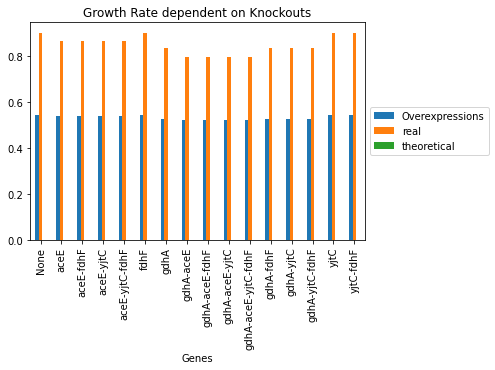

In [ ]:
#knockout_combinations = knockout_combinations.set_index('Genes')
knockout_combinations.pivot("Genes", "Overexpression", values="Growth Rate").plot(kind='bar')
plt.title("Growth Rate dependent on Knockouts")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

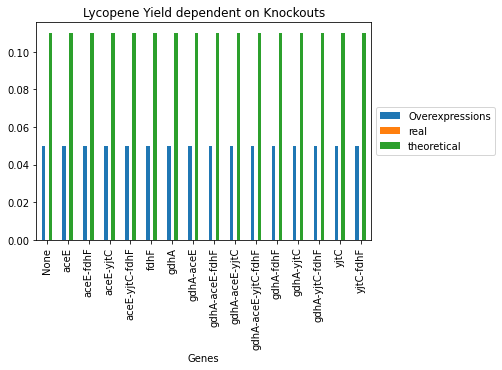

In [ ]:
knockout_combinations.pivot("Genes", "Overexpression", values="Lycopene Yield").plot(kind='bar')
plt.title("Lycopene Yield dependent on Knockouts")
# Put a legend to the right of the current axis
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

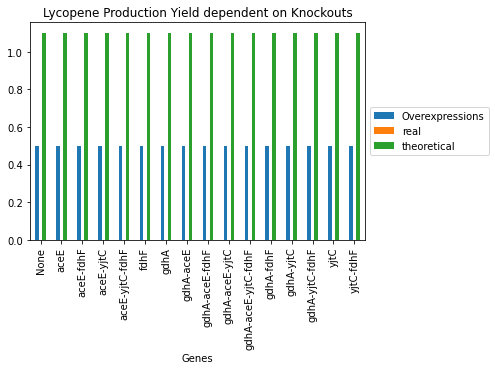

In [ ]:
knockout_combinations.pivot('Genes', 'Overexpression', values='Lycopene Production Yield').plot(kind='bar')
plt.title("Lycopene Production Yield dependent on Knockouts")
# Put a legend to the right of the current axis
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))